In [42]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random

In [ ]:
batch_size = 128
learning_rate = 1e-3 # IKEA
# learning_rate = 1e-4 # MNIST (easier)
num_epochs = 150
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# IKEA
from google.colab import drive
drive.mount('/content/drive')
# root_dir =  "/content/drive/Othercomputers/My MacBook Pro/GitHub/DecorAssist/dataset/images/classified/"
root_dir = "drive/MyDrive/DecorAssist/dataset/images/classified/"
categories = ['bed', 'chair', 'clock', 'couch', 'dining table', 'objects', 'plant_pot']
data = torchvision.datasets.ImageFolder(root=root_dir, transform=transforms.Compose([transforms.Resize(28), transforms.CenterCrop(28), transforms.ToTensor()]))
data_subset = torch.utils.data.Subset(data, range(0, len(data), 10)) # Use subset of dataset
data_loader = torch.utils.data.DataLoader(dataset=data_subset, batch_size=batch_size, shuffle=True)

# MNIST
# data_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)

# Convolutional Autoencoder

In [3]:
class AE(nn.Module):
  def __init__(self, img_channels=3, feature_dim=32*20*20, z_dim=256): # IKEA
  # def __init__(self, img_channels=1, feature_dim=32*20*20, z_dim=256): # MNIST
    super(AE, self).__init__()
    self.encoder_conv1 = nn.Conv2d(img_channels, 16, 5)
    self.encoder_conv2 = nn.Conv2d(16, 32, 5) 
    self.encoder_fc = nn.Linear(feature_dim, z_dim)
    self.decoder_fc = nn.Linear(z_dim, feature_dim)
    self.decoder_conv1 = nn.ConvTranspose2d(32, 16, 5)
    self.decoder_conv2 = nn.ConvTranspose2d(16, img_channels, 5)
      
  def encoder(self, x):
    x = F.relu(self.encoder_conv1(x))
    x = F.relu(self.encoder_conv2(x))
    x = x.view(-1, 32*20*20)
    x = self.encoder_fc(x)
    return x
  
  def decoder(self, z):
    x = F.relu(self.decoder_fc(z))
    x = x.view(-1, 32, 20, 20)
    x = F.relu(self.decoder_conv1(x))
    x = torch.sigmoid(self.decoder_conv2(x))
    return x
      
  def forward(self, x):
    z = self.encoder(x)
    out = self.decoder(z)
    return out, z

In [4]:
ae = AE().to(device)
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [ ]:
for epoch in range(num_epochs):
  for idx, data in enumerate(data_loader, 0):
    imgs, _ = data
    imgs = imgs.to(device)
    out, z = ae(imgs)
    loss = criterion(out, imgs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Epoch {epoch}: Loss {loss}')

Bottleneck: tensor([[-6.6227, -1.3525, -3.1384,  ...,  2.1681, -0.0973, -7.9962],
        [-3.7087, -1.1112, -2.0577,  ...,  4.3968,  1.1533, -6.8199],
        [-4.5368, -1.7289,  1.6727,  ...,  1.4147, -1.7528, -5.8558],
        ...,
        [-6.6801, -4.1595,  4.1725,  ...,  3.0216, -2.1396, -2.8020],
        [-8.6115, -5.8840,  3.9100,  ...,  3.0324, -1.9458, -4.6720],
        [-2.9439, -0.1167,  0.2744,  ...,  2.7079,  0.5002, -4.7465]],
       device='cuda:0')


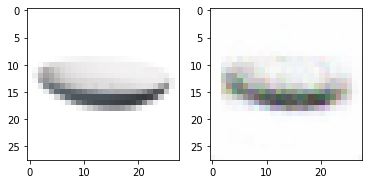

In [13]:
ae.eval()
with torch.no_grad():
  for data in random.sample(list(data_loader), 1):
    imgs, _ = data
    imgs = imgs.to(device)
    img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
    plt.subplot(121)
    plt.imshow(np.squeeze(img))
    out, z = ae(imgs)
    outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
    plt.subplot(122)
    plt.imshow(np.squeeze(outimg))
    print(f'Bottleneck: {z}')

# Convolutional Variational Autoencoder

In [14]:
class VAE(nn.Module):
  def __init__(self, img_channels=3, feature_dim=32*20*20, z_dim=256): # IKEA
  # def __init__(self, img_channels=1, feature_dim=32*20*20, z_dim=256): # MNIST
    super(VAE, self).__init__()
    self.encoder_conv1 = nn.Conv2d(img_channels, 16, 5)
    self.encoder_conv2 = nn.Conv2d(16, 32, 5) 
    self.encoder_fc1 = nn.Linear(feature_dim, z_dim)
    self.encoder_fc2 = nn.Linear(feature_dim, z_dim)
    self.decoder_fc = nn.Linear(z_dim, feature_dim)
    self.decoder_conv1 = nn.ConvTranspose2d(32, 16, 5)
    self.decoder_conv2 = nn.ConvTranspose2d(16, img_channels, 5)
      
  def encoder(self, x):
    x = F.relu(self.encoder_conv1(x))
    x = F.relu(self.encoder_conv2(x))
    x = x.view(-1, 32*20*20)
    mu = self.encoder_fc1(x)
    logVar = self.encoder_fc2(x)
    return mu, logVar
  
  def reparameterize(self, mu, logVar):
    std = torch.exp(logVar / 2)
    eps = torch.randn_like(std)
    return mu + std * eps, std, eps
  
  def decoder(self, z):
    x = F.relu(self.decoder_fc(z))
    x = x.view(-1, 32, 20, 20)
    x = F.relu(self.decoder_conv1(x))
    x = torch.sigmoid(self.decoder_conv2(x))
    return x
    
  def forward(self, x):
    mu, logVar = self.encoder(x)
    z, std, eps = self.reparameterize(mu, logVar)
    out = self.decoder(z)
    return out, mu, std, eps, logVar

In [15]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(num_epochs):
  for idx, data in enumerate(data_loader, 0):
    imgs, _ = data
    imgs = imgs.to(device)
    out, mu, std, eps, logVar = vae(imgs)
    kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
    loss = F.binary_cross_entropy(out, imgs, size_average=False) + kl_divergence
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f'Epoch {epoch}: Loss {loss}')

Bottleneck: tensor([[ 1.6117,  0.4845, -1.2006,  ...,  0.5636,  0.0331,  1.9047],
        [-0.1242,  0.9789,  1.7679,  ...,  0.8869, -1.5984,  0.2388],
        [-0.4619, -0.5372,  0.0174,  ...,  0.2554,  0.0933,  0.0913],
        ...,
        [-1.7102, -2.0688,  0.6616,  ...,  0.1043,  0.4928,  0.6424],
        [ 0.2142, -1.1699, -0.3483,  ...,  0.0251,  1.7029,  0.1538],
        [-0.0462, -0.8881,  0.1090,  ...,  0.7646,  0.6425, -0.1548]],
       device='cuda:0')


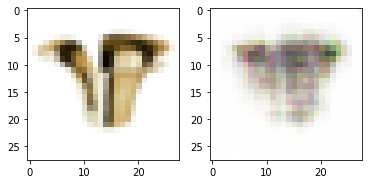

In [41]:
vae.eval()
with torch.no_grad():
  for data in random.sample(list(data_loader), 1):
    imgs, _ = data
    imgs = imgs.to(device)
    img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
    plt.subplot(121)
    plt.imshow(np.squeeze(img))
    out, mu, std, eps, logVar = vae(imgs)
    outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
    plt.subplot(122)
    plt.imshow(np.squeeze(outimg))
    print(f'Bottleneck: {mu + std * eps}')